In [2]:
from pykalman import KalmanFilter
import numpy as np

In [16]:
kf = KalmanFilter(transition_matrices = [[1, 1], [0, 1]], observation_matrices = [[0.1, 0.5], [-0.3, 0.0]])
measurements = np.asarray([[1,0], [0,0], [0,1]])  # 3 observations
kf = kf.em(measurements, n_iter=5)
(filtered_state_means, filtered_state_covariances) = kf.filter(measurements)
(smoothed_state_means, smoothed_state_covariances) = kf.smooth(measurements)

In [17]:
smoothed_state_means

array([[-0.67441149,  0.39899312],
       [-0.81992226,  0.19109279],
       [-1.72967476,  0.29641685]])

fitted model: <pykalman.standard.KalmanFilter object at 0x000002A3792073C8>


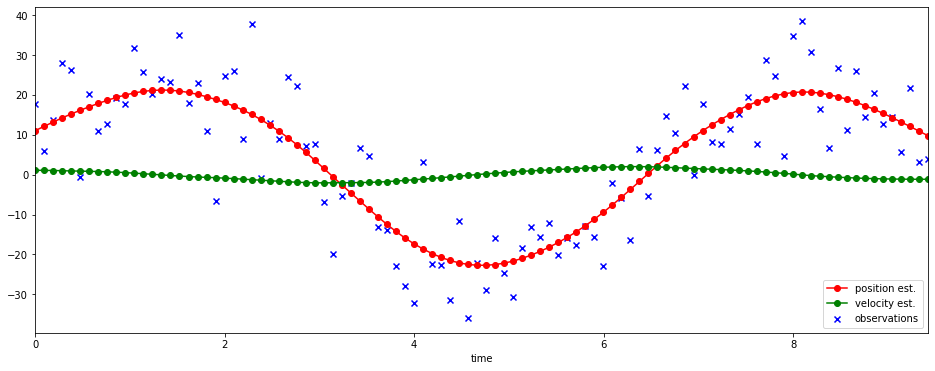

In [5]:
import matplotlib.pylab as pl
rnd = np.random.RandomState(0)

# generate a noisy sine wave to act as our fake observations
n_timesteps = 100
x = np.linspace(0, 3 * np.pi, n_timesteps)
observations = 20 * (np.sin(x) + 0.5 * rnd.randn(n_timesteps))

# create a Kalman Filter by hinting at the size of the state and observation
# space.  If you already have good guesses for the initial parameters, put them
# in here.  The Kalman Filter will try to learn the values of all variables.
kf = KalmanFilter(transition_matrices=np.array([[1, 1], [0, 1]]),
                  transition_covariance=0.01 * np.eye(2))

# You can use the Kalman Filter immediately without fitting, but its estimates
# may not be as good as if you fit first.
states_pred = kf.em(observations).smooth(observations)[0]
print('fitted model: {0}'.format(kf))

# Plot lines for the observations without noise, the estimated position of the
# target before fitting, and the estimated position after fitting.
pl.figure(figsize=(16, 6))
obs_scatter = pl.scatter(x, observations, marker='x', color='b',
                         label='observations')
position_line = pl.plot(x, states_pred[:, 0],
                        linestyle='-', marker='o', color='r',
                        label='position est.')
velocity_line = pl.plot(x, states_pred[:, 1],
                        linestyle='-', marker='o', color='g',
                        label='velocity est.')
pl.legend(loc='lower right')
pl.xlim(xmin=0, xmax=x.max())
pl.xlabel('time')
pl.show()

E:\ProgramData\Anaconda3\lib\site-packages\pykalman\standard.py:1126: RuntimeWarning: covariance is not positive-semidefinite.
  observation_covariance.newbyteorder('=')


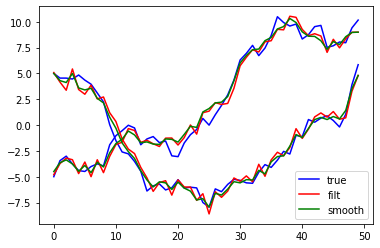

In [6]:
# specify parameters
random_state = np.random.RandomState(0)
transition_matrix = [[1, 0.1], [0, 1]]
transition_offset = [-0.1, 0.1]
observation_matrix = np.eye(2) + random_state.randn(2, 2) * 0.1
observation_offset = [1.0, -1.0]
transition_covariance = np.eye(2)
observation_covariance = np.eye(2) + random_state.randn(2, 2) * 0.1
initial_state_mean = [5, -5]
initial_state_covariance = [[1, 0.1], [-0.1, 1]]

# sample from model
kf = KalmanFilter(
    transition_matrix, observation_matrix, transition_covariance,
    observation_covariance, transition_offset, observation_offset,
    initial_state_mean, initial_state_covariance,
    random_state=random_state
)
states, observations = kf.sample(
    n_timesteps=50,
    initial_state=initial_state_mean
)

# estimate state with filtering and smoothing
filtered_state_estimates = kf.filter(observations)[0]
smoothed_state_estimates = kf.smooth(observations)[0]

# draw estimates
pl.figure()
lines_true = pl.plot(states, color='b')
lines_filt = pl.plot(filtered_state_estimates, color='r')
lines_smooth = pl.plot(smoothed_state_estimates, color='g')
pl.legend((lines_true[0], lines_filt[0], lines_smooth[0]),
          ('true', 'filt', 'smooth'),
          loc='lower right'
)
pl.show()

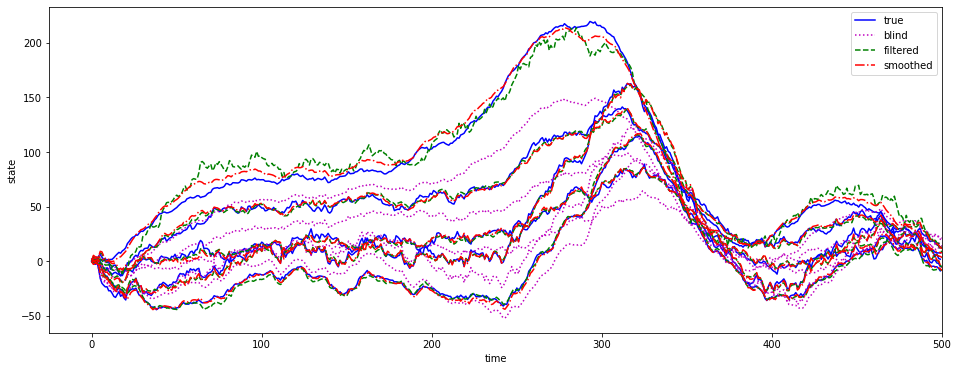

In [32]:
from pykalman.datasets import load_robot

# Load data and initialize Kalman Filter
data = load_robot()
kf = KalmanFilter(
    data.transition_matrix.data,
    data.observation_matrix.data,
    data.initial_transition_covariance.data,
    data.initial_observation_covariance.data,
    data.transition_offsets.data,
    data.observation_offset.data,
    data.initial_state_mean.data,
    data.initial_state_covariance.data,
    em_vars=[
      'transition_matrices', 'observation_matrices',
      'transition_covariance', 'observation_covariance',
      'observation_offsets', 'initial_state_mean',
      'initial_state_covariance'
    ]
)

# Learn good values for parameters named in `em_vars` using the EM algorithm
loglikelihoods = np.zeros(10)
for i in range(len(loglikelihoods)):
    kf = kf.em(X=data.observations.data, n_iter=1)
    #loglikelihoods[i] = kf.loglikelihood(data.observations.data)

# Estimate the state without using any observations.  This will let us see how
# good we could do if we ran blind.
n_dim_state = data.transition_matrix.shape[0]
n_timesteps = data.observations.shape[0]
blind_state_estimates = np.zeros((n_timesteps, n_dim_state))
for t in range(n_timesteps - 1):
    if t == 0:
        blind_state_estimates[t] = kf.initial_state_mean
    blind_state_estimates[t + 1] = (
      np.dot(kf.transition_matrices, blind_state_estimates[t])
      + kf.transition_offsets[t]
    )

# Estimate the hidden states using observations up to and including
# time t for t in [0...n_timesteps-1].  This method outputs the mean and
# covariance characterizing the Multivariate Normal distribution for
#   P(x_t | z_{1:t})
filtered_state_estimates = kf.filter(data.observations)[0]

# Estimate the hidden states using all observations.  These estimates
# will be 'smoother' (and are to be preferred) to those produced by
# simply filtering as they are made with later observations in mind.
# Probabilistically, this method produces the mean and covariance
# characterizing,
#    P(x_t | z_{1:n_timesteps})
smoothed_state_estimates = kf.smooth(data.observations)[0]

# Draw the true, blind,e filtered, and smoothed state estimates for all 5
# dimensions.
pl.figure(figsize=(16, 6))
lines_true = pl.plot(data.states, linestyle='-', color='b')
lines_blind = pl.plot(blind_state_estimates, linestyle=':', color='m')
lines_filt = pl.plot(filtered_state_estimates, linestyle='--', color='g')
lines_smooth = pl.plot(smoothed_state_estimates, linestyle='-.', color='r')
pl.legend(
    (lines_true[0], lines_blind[0], lines_filt[0], lines_smooth[0]),
    ('true', 'blind', 'filtered', 'smoothed')
)
pl.xlabel('time')
pl.ylabel('state')
pl.xlim(xmax=500)

# Draw log likelihood of observations as a function of EM iteration number.
# Notice how it is increasing (this is guaranteed by the EM algorithm)
#pl.figure()
#pl.plot(kf.loglikelihood(data.observations))
#pl.xlabel('em iteration number')
#pl.ylabel('log likelihood')
pl.show()

In [34]:
data.observations.shape

(501, 2)